In [28]:
from tensorflow.keras.models import load_model

model_path = "E:\\documentos\\tcc\\cod\\modelos\\CustomAlex1\\CustomAlex-augmentation.h5"
model = load_model(model_path)

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 62, 62, 96)        34944     
_________________________________________________________________
batch_normalization (BatchNo (None, 62, 62, 96)        384       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 30, 30, 96)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 30, 30, 64)        153664    
_________________________________________________________________
batch_normalization_1 (Batch (None, 30, 30, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 96)        5

In [29]:
from tensorflow.keras.preprocessing import image
import numpy as np

img_path = 'E:\\retinopatia-dataset\\train\\13_left.jpeg'

img = image.load_img(img_path, target_size=(256, 256))
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
img_tensor /= 255.

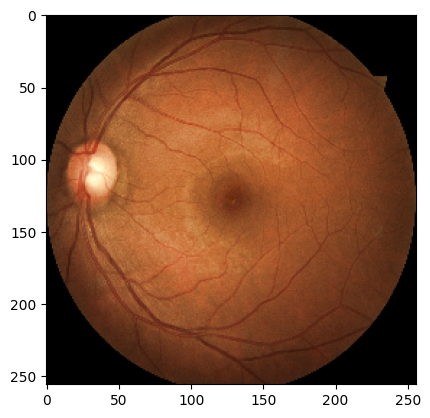

In [30]:
import matplotlib.pyplot as plt
plt.imshow(img_tensor[0])
plt.show()

In [31]:
from tensorflow.keras import models
# extract output of top 8 layers
layer_outputs = [layer.output for layer in model.layers[:8]] 
# Creates a model that will return these
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)
# Returns a list of five Numpy arrays: one array per layer activation
activations = activation_model.predict(img_tensor)

first_layer_activation = activations[0]
# 62x62 feature map with 96 layers
print(first_layer_activation.shape)

(1, 62, 62, 96)


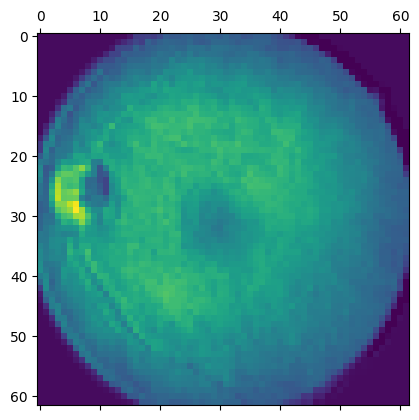

In [32]:
plt.matshow(first_layer_activation[0, :, :, 50], cmap='viridis')

C:\Users\kant\AppData\Local\Temp\ipykernel_14240\3424536610.py:20: RuntimeWarning: invalid value encountered in true_divide
  channel_image /= channel_image.std()
C:\Users\kant\AppData\Local\Temp\ipykernel_14240\3424536610.py:20: RuntimeWarning: divide by zero encountered in true_divide
  channel_image /= channel_image.std()


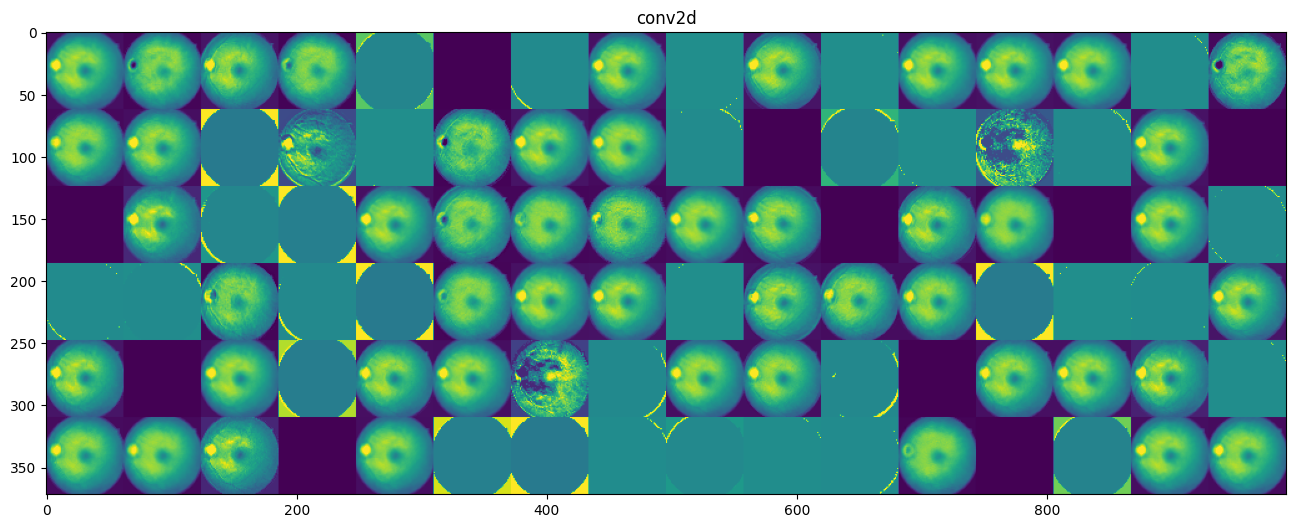

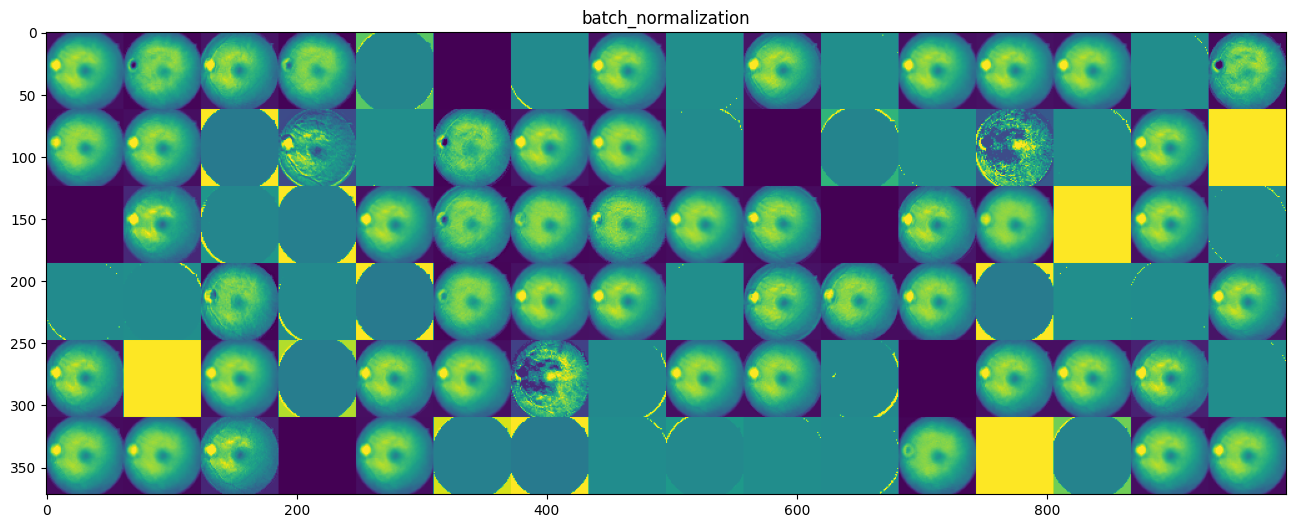

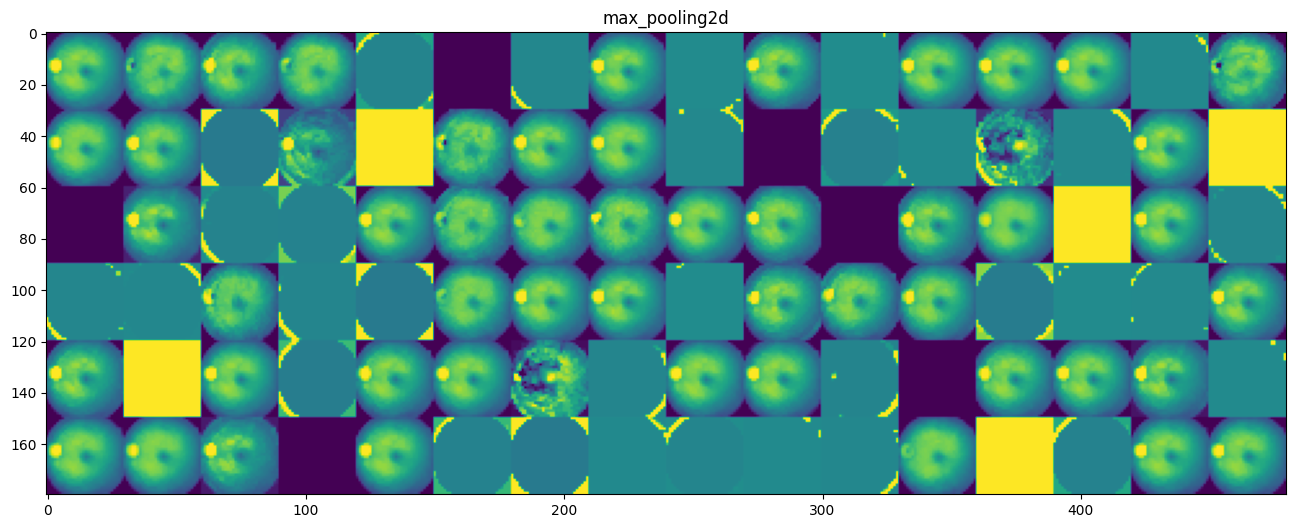

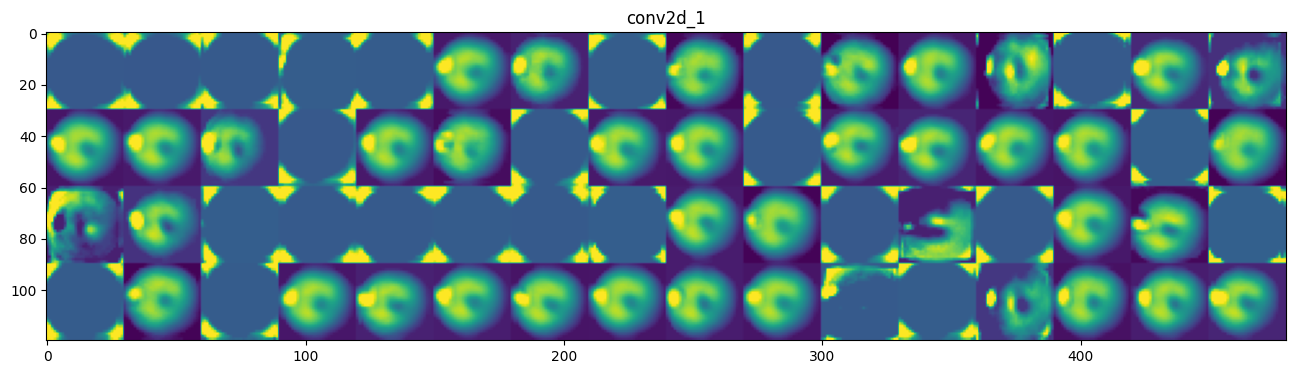

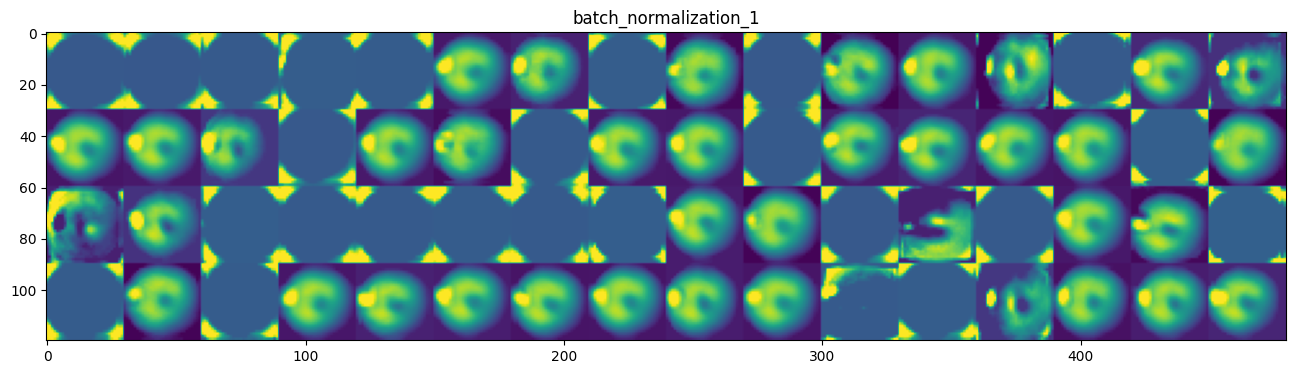

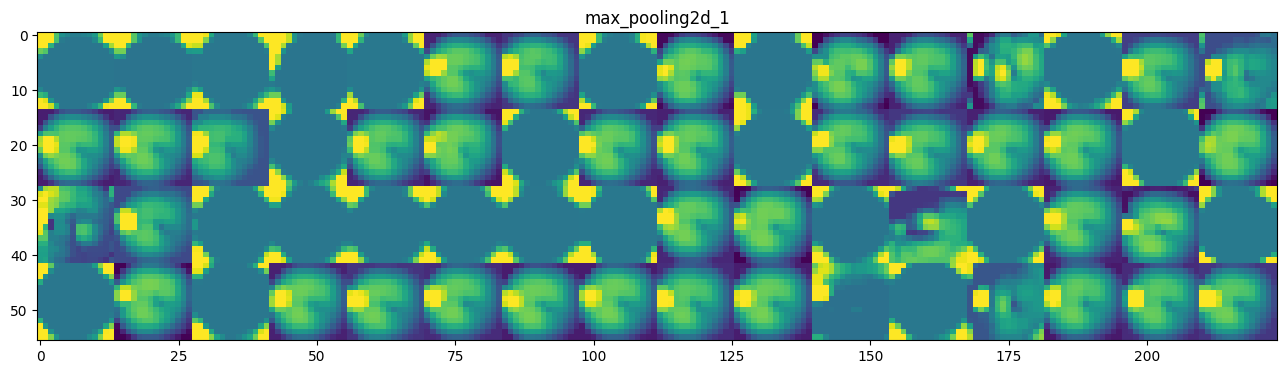

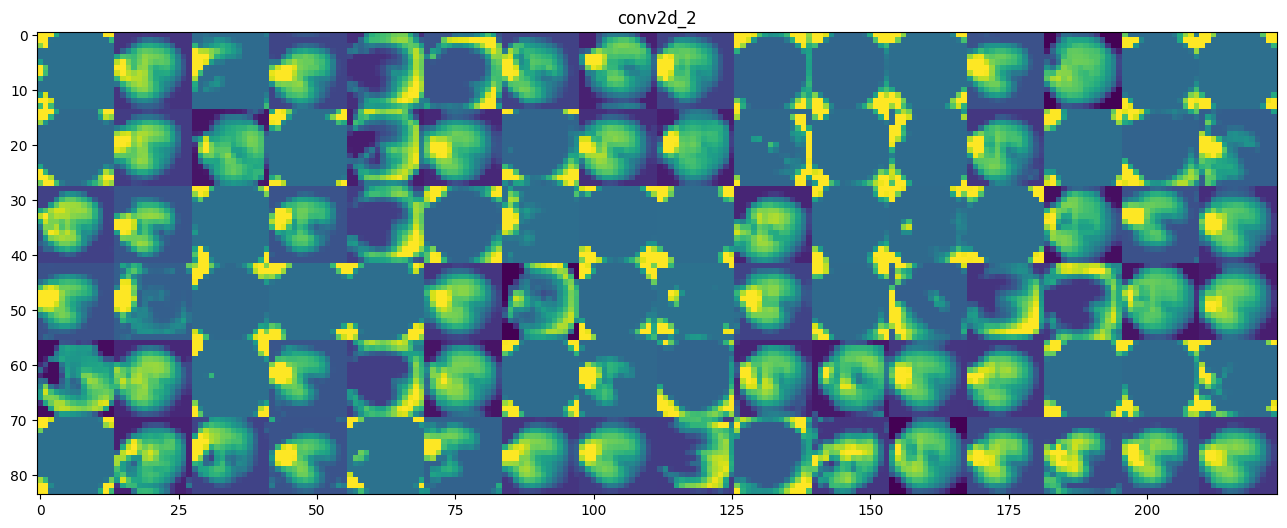

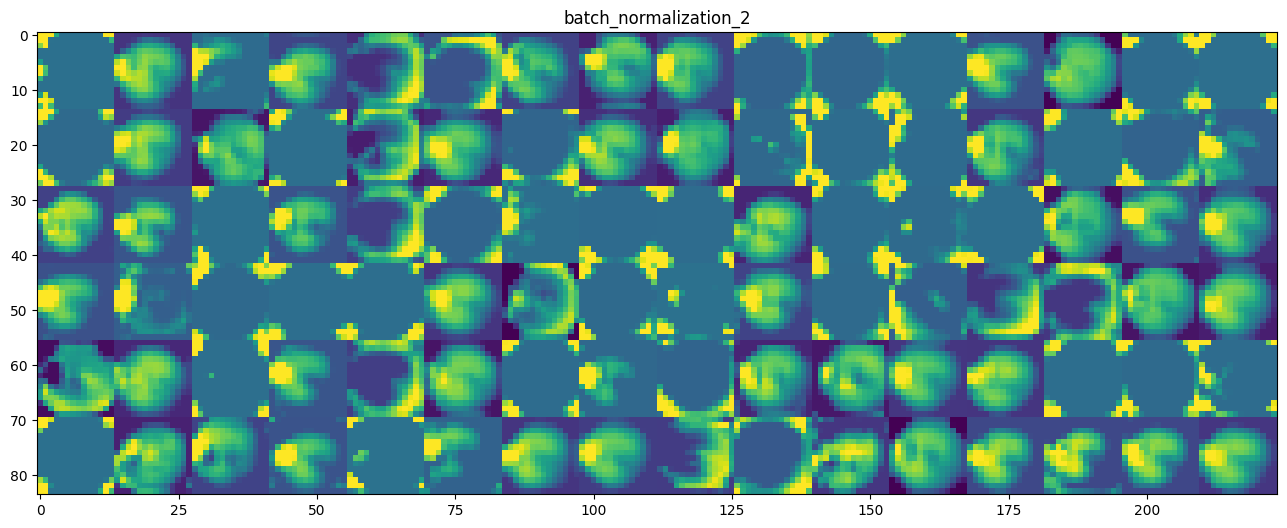

In [33]:
layer_names = []

for layer in model.layers[:8]:
    layer_names.append(layer.name)

images_per_row = 16

for layer_name, layer_activation in zip(layer_names, activations):
    n_features = layer_activation.shape[-1]
    
    size = layer_activation.shape[1]
    
    n_cols = n_features // images_per_row
    display_grid = np.zeros((size * n_cols, images_per_row * size))
    
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image = layer_activation[0, :, :, col * images_per_row + row]
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size, row * size : (row + 1) * size] = channel_image

    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
    scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')

In [34]:
# img_path = '/Users/fchollet/Downloads/creative_commons_elephant.jpg'
# img = image.load_img(img_path, target_size=(224, 224))
# x = image.img_to_array(img)
# x = np.expand_dims(x, axis=0)
# x = preprocess_input(x)
x = img_tensor

preds = model.predict(x)
print('Predicted:', preds)

african_elephant_output = model.output[:, 1]
last_conv_layer = model.get_layer('conv2d_2')

Predicted: [[0.22730893 0.23548119 0.2495646  0.14074887 0.14689635]]


In [35]:
import tensorflow as tf

# Define a function for the computation
@tf.function
def compute_gradient_pooled_values(input_tensor, model, last_conv_layer_output):
    # Create a context for gradient computation
    with tf.GradientTape() as tape:
        # Forward pass
        african_elephant_output = model(input_tensor)  # Replace with your input tensor

        # Define the loss or target you want to maximize/minimize
        loss = african_elephant_output

    # Get the gradients of the loss with respect to the last_conv_layer_output
    gradients = tape.gradient(loss, last_conv_layer_output)

    # Calculate the mean of gradients
    pooled_grads = tf.reduce_mean(gradients, axis=(0, 1, 2))
    
    return pooled_grads

In [36]:
import tensorflow as tf
import numpy as np
import cv2

def generate_grad_cam(model, last_conv_layer_name, target_class, img_array):
    with tf.GradientTape() as tape:
        last_conv_layer = model.get_layer(last_conv_layer_name)
        iterate = tf.keras.models.Model([model.inputs], [model.output, last_conv_layer.output])
        model_out, last_conv_layer = iterate(img_array)
        loss = model_out[:, target_class]

    grads = tape.gradient(loss, last_conv_layer)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    last_conv_layer_output = last_conv_layer[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    heatmap = tf.maximum(heatmap, 0)
    heatmap /= tf.reduce_max(heatmap)
    return heatmap

(256, 256, 3)


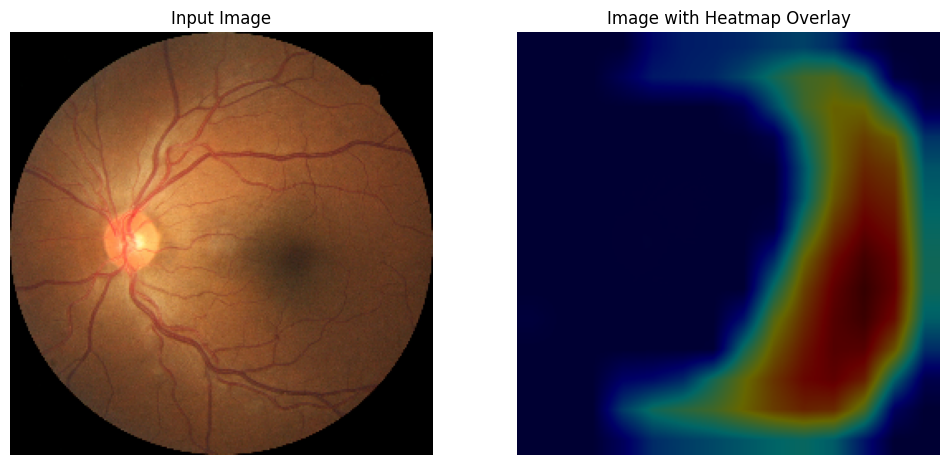

In [74]:
img_path = 'E:\\retinopatia-dataset\\train\\17_left.jpeg'
img = image.load_img(img_path, target_size=(256, 256))
img = image.img_to_array(img)
img /= 255.
print(img.shape)
img_tensor = tf.expand_dims(img, axis=0)  # Expand dimensions to create a batch of one image

# Choose the class index for which you want to generate the heatmap
target_class = 1  # Change to your desired class

# Generate the class activation map
heatmap = generate_grad_cam(model, 'conv2d_4', target_class, img_tensor)

# Convert the heatmap tensor to a NumPy array
heatmap = heatmap.numpy()

# Ensure that the heatmap has the same shape as the input image
heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]), interpolation=cv2.INTER_LINEAR)

# Overlay the heatmap on the input image
img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
heatmap = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET)
img_with_heatmap = cv2.addWeighted(img, 0.6, heatmap, 0.4, 0, dtype=cv2.CV_8U)

# Display the input image and the image with the overlay
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title('Input Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(img_with_heatmap, cv2.COLOR_BGR2RGB))
plt.title('Image with Heatmap Overlay')
plt.axis('off')

plt.show()